In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

plt.rc('axes', labelsize=15, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=15)

# Throughput

In [ ]:
THRP_PREFIX = "main/ycsb"

IGNORE_CACHE = False

thrp_index_df = from_cache_or_compute(
    f'{THRP_PREFIX}/index.parquet',
    lambda: get_index(spark, THRP_PREFIX).toPandas().convert_dtypes().astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    }),
    ignore_cache=IGNORE_CACHE,
)
thrp_index_df

In [ ]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_df):
    # Extract all prefixes in the index
    throughput_df = index_df.loc[:, ["prefix"]]
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{THRP_PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(thrp_index_df),
    ignore_cache=IGNORE_CACHE,
)

## Plot

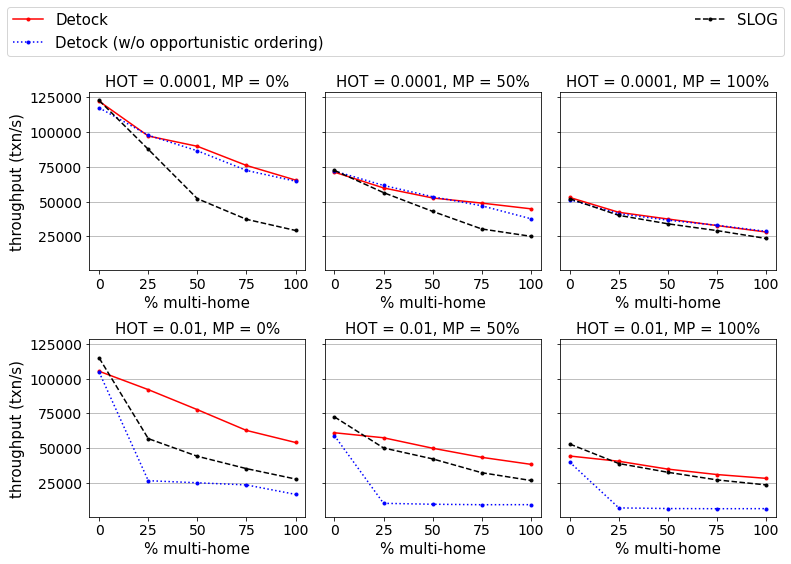

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(11, 7), sharey=True)

configs = ["ddr_ts.conf", "ddr_only.conf", "baseline.conf"]
mp_pcts = sorted(throughput_df["wl:mp"].unique())
mh_pcts = sorted(throughput_df["wl:mh"].unique())
hots = sorted(throughput_df["wl:hot"].unique(), reverse=True)

ignored_configs = ['ddr_only_no_ddr.conf', 'ddr_ts_no_ddr.conf']

config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (w/o opportunistic ordering)',
    'ddr_ts.conf': 'Detock'
}

pc = cycler(linestyle=['-', ':', '--']) + cycler(color='rbk')
for ax_r in axes:
    for ax in ax_r:
        ax.set_prop_cycle(pc)

for config in configs:
    if config in ignored_configs:
        continue
    for r, hot in enumerate(hots):
        for c, mp_pct in enumerate(mp_pcts):
            mask = (throughput_df["config_name"] == config) & (throughput_df["wl:mp"] == mp_pct) & (throughput_df["wl:hot"] == hot)
            label = config_to_label[config] if r == 0 and c == 0 else '_nolegend_'
            filtered = throughput_df[mask].sort_values("wl:mh")
            filtered.plot(ax=axes[r, c], x="wl:mh", y="throughput", label=label, marker='.', legend=False)
            axes[r, c].set_title(f"HOT = {1/hot}, MP = {mp_pct}%")
            axes[r, c].set_ylabel("throughput (txn/s)")
            axes[r, c].set_xlabel("% multi-home")
            axes[r, c].set_xticks(mh_pcts)
            axes[r, c].grid(axis='y')

fig.tight_layout()
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=2)

fig.savefig('output/micro-throughput.pdf', bbox_inches='tight')


# Deadlocks

In [ ]:
deadlocks_index_df = thrp_index_df[(
    (thrp_index_df["wl:hot"] == 100) &
    (thrp_index_df["wl:mp"] == 50) &
    (
        (thrp_index_df["config_name"] == "ddr_ts.conf") |
        (thrp_index_df["config_name"] == "ddr_only.conf")
    )
)]
deadlocks_index_df

In [ ]:
import pickle

mh_pcts = [25, 50, 75, 100]

configs = ["ddr_ts.conf", "ddr_only.conf"]
config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (w/o opportunistic ordering)',
    'ddr_ts.conf': 'Detock'
}

# Collect data
DEADLOCKS_PATH = f'{THRP_PREFIX}/deadlocks.pickle'

data = []
if isfile(DEADLOCKS_PATH):
    with open(DEADLOCKS_PATH, 'rb') as f:
        data = pickle.load(f)
else:
    for config in configs:
        deadlocks = []
        num_txns = []
        for mh in mh_pcts:
            mask = (deadlocks_index_df["config_name"] == config) & (deadlocks_index_df["wl:mh"] == mh)
            prefix = deadlocks_index_df.loc[mask, "prefix"].iloc[0]
            
            deadlocks_df = deadlocks_csv(spark, prefix).where(col("replica") == 0).toPandas()

            deadlocks.append(deadlocks_df["vertices"])
            num_txns.append(committed(spark, prefix))

        data.append((deadlocks, num_txns))

    with open(DEADLOCKS_PATH, 'wb') as f:
        pickle.dump(data, f)
        print(f'Saved to: {DEADLOCKS_PATH}')

# Plot
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 7))
colors='rb'
hatches = ['', '/']
for i, c in enumerate(configs):
    deadlocks, num_txns = data[i]
    data_cnt = list(map(lambda d : d[0].count(), zip(deadlocks, num_txns)))
    pos = [j * (len(configs) + 1) + i for j in range(len(data_cnt))]

    l = axes[0].bar(pos, data_cnt, label=config_to_label[c], hatch=hatches[i], fill=False, edgecolor=colors[i])
    color = l.get_children()[-1].get_facecolor()

    box = axes[1].boxplot(
        deadlocks,
        flierprops={ 'markersize': 1 },
        medianprops={ 'color': 'black' },
        positions=pos,
        manage_ticks=False,
        patch_artist=True,
    )
    for b in box['boxes']:
        b.set_fill(False)
        b.set_hatch(hatches[i])
        b.set_edgecolor(colors[i])
    
ticks = []
ticklabels = []
for i, mh in enumerate(mh_pcts):
    start = i * (len(configs) + 1)
    end = start + len(configs)
    ticks.append((start + end - 1) / 2)
    ticklabels.append(f'{mh}')
    
axes[0].set_ylabel('number of deadlocks')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticklabels)
axes[0].grid(axis='y')

axes[1].set_xlabel("% multi-home")
axes[1].set_ylabel('size of a deadlock')
axes[1].set_yscale("log")
axes[1].grid(axis='y')

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=1)
fig.tight_layout()
fig.savefig('output/micro-deadlocks.pdf', bbox_inches='tight')

# Latency

In [ ]:
LAT_PREFIX = "main/ycsb-latency"

IGNORE_CACHE = False

lat_index_df = from_cache_or_compute(
    f'{LAT_PREFIX}/index.parquet',
    lambda: get_index(spark, LAT_PREFIX).toPandas().convert_dtypes().astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    }),
    ignore_cache=IGNORE_CACHE
)

lat_index_df

In [ ]:
IGNORE_CACHE = False

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("percentile_50"),
    F.percentile_approx("latency", 0.90).alias("percentile_90"),
    F.percentile_approx("latency", 0.95).alias("percentile_95"),
    F.percentile_approx("latency", 0.99).alias("percentile_99"),
]

# latency_pct_sh_df = from_cache_or_compute(
#     f'{LAT_PREFIX}/latency_sh.parquet',
#     lambda: latency(spark, lat_index_df["prefix"])\
#         .where(F.size("replicas") == 1)\
#         .groupBy("prefix")\
#         .agg(*percentile_cols)\
#         .toPandas()\
#         .merge(lat_index_df, on="prefix"),
#     ignore_cache=IGNORE_CACHE,
# )

# latency_pct_mh_df = from_cache_or_compute(
#     f'{LAT_PREFIX}/latency_mh.parquet',
#     lambda: latency(spark, lat_index_df["prefix"])\
#         .where(F.size("replicas") > 1)\
#         .groupBy("prefix")\
#         .agg(*percentile_cols)\
#         .toPandas()\
#         .merge(lat_index_df, on="prefix"),
#     ignore_cache=IGNORE_CACHE,
# )

latency_pct_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency.parquet',
    lambda: latency(spark, lat_index_df["prefix"])\
        .groupBy("prefix")\
        .agg(*percentile_cols)\
        .toPandas()\
        .merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)


## Plot

In [40]:
def plot_latency(
    df,
    mp_pcts=[0, 50, 100],
    mh_pcts=[0, 25, 50, 75, 100],
    hots=[10000, 100],
    scale='log',
    figsize=(11, 7),
    legend=True,
):
    fig, axes = plt.subplots(len(hots), len(mp_pcts), figsize=figsize, sharey=False)
    axes = np.array(axes).reshape((len(hots), len(mp_pcts)))
    configs = ["ddr_ts.conf", "ddr_only.conf", "baseline.conf"]

    config_to_label = {
        'ddr_ts.conf': 'Detock',
        'baseline.conf': 'SLOG',
        'ddr_only.conf': 'Detock w.o OO',
    }

    pc = (cycler(color='rbk') + cycler(marker=['.', 'x', '.'])) * cycler(linestyle=[':', '--', '-'])
    for ax_r in axes:
        for ax in ax_r:
            ax.set_prop_cycle(pc)

    for i, config in enumerate(configs):
        for r, hot in enumerate(hots):   
            for c, mp_pct in enumerate(mp_pcts):
                mask = (df["config_name"] == config) & (df["wl:mp"] == mp_pct) & (df["wl:hot"] == hot)
                filtered = df[mask].sort_values("wl:mh")
                label = config_to_label[config] + ' {}' if r == 0 and c == 0 else '_nolegend_'

                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_50", label=label.format('p50'), legend=False)
                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_95", label=label.format('p95'), legend=False)
                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_99", label=label.format('p99'), legend=False)

                axes[r, c].set_title(f"HOT = {1/hot}, MP = {mp_pct}%")
                axes[r, c].set_ylabel("latency (ms)")
                axes[r, c].set_xlabel("% multi-home")
                axes[r, c].set_xticks(mh_pcts)
                axes[r, c].grid(axis='y')
                axes[r, c].set_yscale(scale)

    if legend:
        fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=3)

    return fig, axes


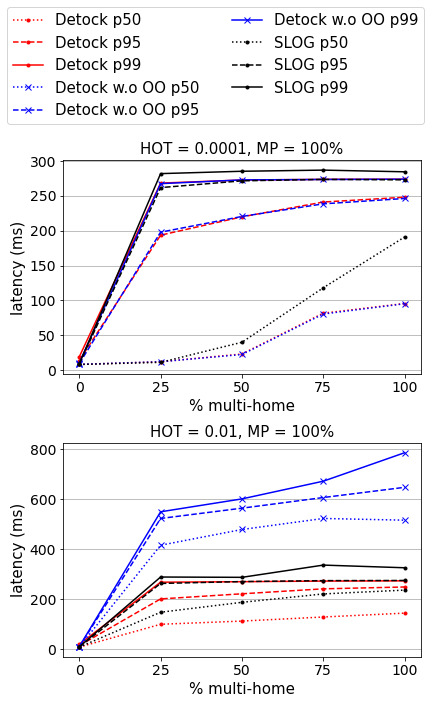

In [41]:
fig, _ = plot_latency(latency_pct_df, mp_pcts=[100], scale='linear', figsize=(6, 8), legend=False)
fig.legend(bbox_to_anchor=(0, 1, 1, 0), mode='expand', ncol=2, loc='lower left')
fig.tight_layout()
fig.savefig('output/micro-latency.pdf', bbox_inches='tight')
